## Raw audio → causal dilated 1D convolutions (WaveNet / TCN) → residual + skip connections → global pooling → classifier

In [2]:
import os
import torch
import torchaudio
import soundfile as sf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"

SAMPLE_RATE = 16000
BATCH_SIZE = 16
EPOCHS = 40

CLASSES = ['down', 'left', 'off', 'on', 'right', 'stop', 'up']
NUM_CLASSES = len(CLASSES)

MAX_LEN = SAMPLE_RATE

/opt/miniconda3/envs/Lesson_44/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class SpeechCommandsDataset(Dataset):
    def __init__(self, root_dir, classes):
        self.files = []
        self.labels = []

        for label, cls in enumerate(classes):
            cls_dir = os.path.join(root_dir, cls)
            for fname in os.listdir(cls_dir):
                if fname.endswith(".wav"):
                    self.files.append(os.path.join(cls_dir, fname))
                    self.labels.append(label)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        wav_np, sr = sf.read(self.files[idx], dtype="float32")
        waveform = torch.from_numpy(wav_np)

        if waveform.ndim == 1:
            pass
        else:
            waveform = waveform.mean(dim=1)

        # Pad / truncate
        if waveform.shape[0] < MAX_LEN:
            pad = MAX_LEN - waveform.shape[0]
            waveform = F.pad(waveform, (0, pad))
        else:
            waveform = waveform[:MAX_LEN]

        return waveform.unsqueeze(0), self.labels[idx]

In [4]:
class CausalConv1d(nn.Conv1d):
    def __init__(self, *args, **kwargs):
        kwargs.setdefault("padding", 0)
        super().__init__(*args, **kwargs)
        self.left_padding = (self.kernel_size[0] - 1) * self.dilation[0]

    def forward(self, x):
        x = F.pad(x, (self.left_padding, 0))
        return super().forward(x)


In [5]:
class WaveNetBlock(nn.Module):
    def __init__(self, channels, dilation):
        super().__init__()

        self.filter_conv = CausalConv1d(
            channels, channels, kernel_size=2, dilation=dilation
        )
        self.gate_conv = CausalConv1d(
            channels, channels, kernel_size=2, dilation=dilation
        )

        self.residual = nn.Conv1d(channels, channels, kernel_size=1)
        self.skip = nn.Conv1d(channels, channels, kernel_size=1)

    def forward(self, x):
        f = torch.tanh(self.filter_conv(x))
        g = torch.sigmoid(self.gate_conv(x))
        z = f * g

        return self.residual(z) + x, self.skip(z)

In [6]:
class WaveNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.input_conv = nn.Conv1d(1, 64, kernel_size=1)

        self.blocks = nn.ModuleList()
        dilations = [1, 2, 4, 8, 16, 32]

        for d in dilations:
            self.blocks.append(WaveNetBlock(64, d))

        self.output = nn.Sequential(
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.input_conv(x)

        skip_connections = []

        for block in self.blocks:
            x, skip = block(x)
            skip_connections.append(skip)

        x = sum(skip_connections)
        return self.output(x)

In [7]:
DATA_ROOT = "speech_commands"

dataset = SpeechCommandsDataset(DATA_ROOT, CLASSES)

idx = list(range(len(dataset)))
train_idx, val_idx = train_test_split(idx, test_size=0.2, random_state=42)

train_ds = torch.utils.data.Subset(dataset, train_idx)
val_ds   = torch.utils.data.Subset(dataset, val_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE)

In [8]:
model = WaveNetClassifier(NUM_CLASSES).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

BEST_MODEL_PATH = "best_wavenet_speech.pt"
CHECKPOINT_PATH = "wavenet_checkpoint.pt"

RESUME_TRAINING = True
MANUAL_START_EPOCH = 7

In [ ]:
start_epoch = 0
best_acc = 0.0
best_epoch = 0

if RESUME_TRAINING and os.path.exists(CHECKPOINT_PATH):
    ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    model.load_state_dict(ckpt["model_state_dict"])
    optimizer.load_state_dict(ckpt["optimizer_state_dict"])
    start_epoch = ckpt["epoch"] + 1
    best_acc = ckpt.get("best_acc", 0.0)
    best_epoch = ckpt.get("best_epoch", 0)
    print(f"Resume from checkpoint: epoch {start_epoch}/{EPOCHS}, best_acc={best_acc:.4f}")
elif RESUME_TRAINING and os.path.exists(BEST_MODEL_PATH):
    model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=DEVICE))
    start_epoch = MANUAL_START_EPOCH
    print(f"Checkpoint not found. Loaded best weights, continue from epoch {start_epoch}/{EPOCHS}")

for epoch in range(start_epoch, EPOCHS):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for x, y in tqdm(train_loader, desc=f"Train {epoch+1}/{EPOCHS}"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_loss /= len(train_loader)
    train_acc = train_correct / train_total

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc=f"Val   {epoch+1}/{EPOCHS}"):
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            logits = model(x)
            loss = criterion(logits, y)

            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    print(
        f"[{epoch+1:2d}/{EPOCHS}] "
        f"train loss: {train_loss:.4f}  acc: {train_acc:.4f} | "
        f"val loss: {val_loss:.4f}  acc: {val_acc:.4f}"
    )

    if val_acc > best_acc:
        best_acc = val_acc
        best_epoch = epoch + 1
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"-> new best model saved (acc = {val_acc:.4f})")

    torch.save(
        {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_acc": best_acc,
            "best_epoch": best_epoch,
        },
        CHECKPOINT_PATH,
    )

print(f"\nBest val accuracy: {best_acc:.4f} at epoch {best_epoch}")

Resume from checkpoint: epoch 30/40, best_acc=0.7836


Val   31/40: 100%|██████████| 206/206 [00:54<00:00,  3.76it/s]


[31/40] train loss: 0.6211  acc: 0.8012 | val loss: 0.7006  acc: 0.7824


Val   32/40: 100%|██████████| 206/206 [00:55<00:00,  3.71it/s]


[32/40] train loss: 0.6130  acc: 0.8065 | val loss: 0.7169  acc: 0.7657


Val   33/40: 100%|██████████| 206/206 [00:57<00:00,  3.61it/s]


[33/40] train loss: 0.6025  acc: 0.8097 | val loss: 0.6811  acc: 0.7915
-> new best model saved (acc = 0.7915)


Val   34/40: 100%|██████████| 206/206 [00:57<00:00,  3.58it/s]


[34/40] train loss: 0.6009  acc: 0.8109 | val loss: 0.6647  acc: 0.7882


Val   35/40: 100%|██████████| 206/206 [01:03<00:00,  3.23it/s]


[35/40] train loss: 0.6041  acc: 0.8090 | val loss: 0.7135  acc: 0.7706


Val   36/40: 100%|██████████| 206/206 [01:04<00:00,  3.19it/s]


[36/40] train loss: 0.5860  acc: 0.8152 | val loss: 0.8406  acc: 0.7411


Val   37/40: 100%|██████████| 206/206 [00:58<00:00,  3.55it/s]


[37/40] train loss: 0.5804  acc: 0.8148 | val loss: 0.7307  acc: 0.7712


Train 38/40:  91%|█████████ | 751/824 [10:37<01:50,  1.51s/it]

In [9]:
model.load_state_dict(torch.load("best_wavenet_speech.pt", map_location=DEVICE))
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in val_loader:
        logits = model(x.to(DEVICE))
        preds = torch.argmax(logits, dim=1)

        y_true.extend(y.numpy())
        y_pred.extend(preds.cpu().numpy())

Accuracy: 0.7915022761760243
              precision    recall  f1-score   support

        down     0.8343    0.6404    0.7246       456
        left     0.8071    0.8155    0.8113       477
         off     0.7352    0.8556    0.7908       464
          on     0.7442    0.7934    0.7680       484
       right     0.7793    0.8900    0.8310       500
        stop     0.9080    0.8047    0.8532       466
          up     0.7707    0.7277    0.7486       448

    accuracy                         0.7915      3295
   macro avg     0.7970    0.7896    0.7896      3295
weighted avg     0.7966    0.7915    0.7904      3295



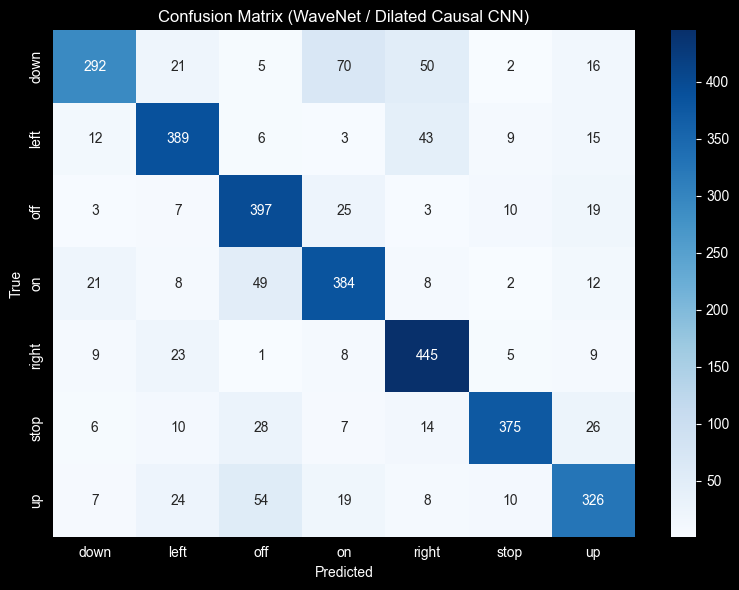

In [10]:
print("Accuracy:", accuracy_score(y_true, y_pred))

print(
    classification_report(
        y_true, y_pred,
        target_names=CLASSES,
        digits=4
    )
)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=CLASSES,
    yticklabels=CLASSES,
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (WaveNet / Dilated Causal CNN)")
plt.tight_layout()
plt.show()
